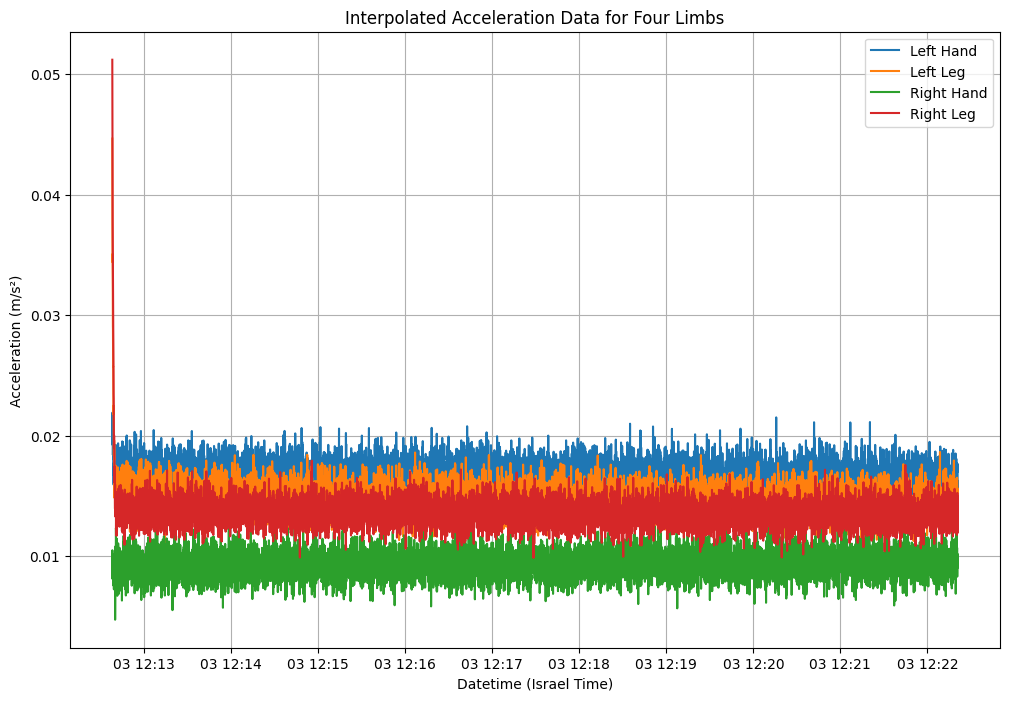

In [115]:
import h5py
import numpy as np
from datetime import datetime, timedelta
import pytz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Load the HDF5 file
file_path = '../data/Mobile.2024.12.03.5000.04.011.sensor.h5'
file_path_meta = '../data/Mobile.2024.12.03.5000.04.011.h5'

# Step 1: Load and extract data for all four limbs
limb_data = {}
with h5py.File(file_path, 'r') as h5_file:
    limb_data['Left Hand'] = h5_file['measurement/MetaWear Sensors Control/left_hand_data'][:]
    limb_data['Left Leg'] = h5_file['measurement/MetaWear Sensors Control/left_leg_data'][:]
    limb_data['Right Hand'] = h5_file['measurement/MetaWear Sensors Control/right_hand_data'][:]
    limb_data['Right Leg'] = h5_file['measurement/MetaWear Sensors Control/right_leg_data'][:]

# Step 2: Convert timestamps to actual date and time
epoch_start = datetime(1970, 1, 1)  # Unix epoch
formatted_data = {}
for limb, time_accel in limb_data.items():
    times = [epoch_start + timedelta(seconds=t) for t in time_accel[:, 0]]
    formatted_data[limb] = {
        "datetime": np.array(times),
        "acceleration": time_accel[:, 1]
    }

# Step 3: Adjust timestamps to Israel timezone
israel_tz = pytz.timezone("Asia/Jerusalem")
formatted_data_israel = {}
for limb, data in formatted_data.items():
    times_israel = [t.replace(tzinfo=pytz.utc).astimezone(israel_tz) for t in data["datetime"]]
    formatted_data_israel[limb] = {
        "datetime": np.array(times_israel),
        "acceleration": data["acceleration"]
    }

# Step 4: Create a unified timeline with 50 ms (0.05 seconds) period
start_time = max(data["datetime"][0] for data in formatted_data_israel.values())
end_time = min(data["datetime"][-1] for data in formatted_data_israel.values())
unified_timeline = np.arange(start_time.timestamp(), end_time.timestamp(), 0.05)

# Step 5: Interpolate the data for all limbs onto the unified timeline
interpolated_data = {}
for limb, data in formatted_data_israel.items():
    # Convert datetime to timestamps for interpolation
    timestamps = np.array([dt.timestamp() for dt in data["datetime"]])
    acceleration = data["acceleration"]
    
    # Create interpolation function
    interp_func = interp1d(timestamps, acceleration, kind='linear', fill_value="extrapolate")
    
    # Apply interpolation on the unified timeline
    interpolated_acceleration = interp_func(unified_timeline)
    interpolated_data[limb] = interpolated_acceleration

# Step 6: Plot the interpolated data
plt.figure(figsize=(12, 8))
unified_datetime = [datetime.fromtimestamp(ts, tz=israel_tz) for ts in unified_timeline]
for limb, interpolated_accel in interpolated_data.items():
    plt.plot(unified_datetime, interpolated_accel, label=limb)

plt.title("Interpolated Acceleration Data for Four Limbs")
plt.xlabel("Datetime (Israel Time)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid()
plt.show()


In [116]:
# create a new dataframe from interpolated_data and unified_datetime
interpolated_df = pd.DataFrame(interpolated_data, index=unified_datetime)
interpolated_df.index.name = 'datetime'
interpolated_df

,Left Hand,Left Leg,Right Hand,Right Leg
datetime,,,,
2024-12-03 12:12:37.926599+02:00,0.020422,0.044643,0.009029,0.051184
2024-12-03 12:12:37.976599+02:00,0.021644,0.039520,0.010486,0.047750
2024-12-03 12:12:38.026599+02:00,0.021908,0.036125,0.009907,0.045972
2024-12-03 12:12:38.076599+02:00,0.019832,0.034385,0.008102,0.043544
2024-12-03 12:12:38.126599+02:00,0.019218,0.035065,0.008732,0.040533
...,...,...,...,...
2024-12-03 12:22:20.776043+02:00,0.016394,0.015626,0.009943,0.012588
2024-12-03 12:22:20.826043+02:00,0.015944,0.015448,0.010185,0.012631
2024-12-03 12:22:20.876043+02:00,0.015329,0.013933,0.009022,0.011918


In [117]:
import h5py
import pandas as pd
from datetime import datetime
import pytz

# Load the HDF5 file

# Step 1: Extract the events table from the HDF5 file
events_data = None
with h5py.File(file_path_meta, 'r') as h5_file:
    events_data = h5_file['measurement/Task Management/events'][:]

# Step 2: Convert to a pandas DataFrame for better readability
events_table = pd.DataFrame(events_data, columns=["Event Name", "Event Type", "Timestamp"])

# Step 3: Decode byte strings to plain strings using map
events_table["Event Name"] = events_table["Event Name"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
events_table["Event Type"] = events_table["Event Type"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
events_table["Timestamp"] = events_table["Timestamp"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Step 4: Group by Event Name and organize into a new table with Start Time and End Time
events_grouped = events_table.groupby("Event Name")
manipulated_table = pd.DataFrame(columns=["Event Name", "Start Time", "End Time"])

for event_name, group in events_grouped:
    start_time = group[group["Event Type"] == "Start"]["Timestamp"].values
    end_time = group[group["Event Type"] == "End"]["Timestamp"].values
    manipulated_table = pd.concat([
        manipulated_table,
        pd.DataFrame({
            "Event Name": [event_name],
            "Start Time": start_time[0] if len(start_time) > 0 else None,
            "End Time": end_time[0] if len(end_time) > 0 else None
        })
    ], ignore_index=True)

# Step 5: Filter out "Task" and "Fixation" events
filtered_table = manipulated_table[
    ~manipulated_table["Event Name"].isin(["Task", "Fixation"])
]

# Step 6: Sort the table by Start Time
filtered_table_sorted = filtered_table.sort_values(by="Start Time").reset_index(drop=True)

# Step 7: Display the final table
print(filtered_table_sorted)


   Event Name                  Start Time                    End Time
0   Base Line  2024-12-03T12:12:42.164308  2024-12-03T12:14:42.192238
1     Connect  2024-12-03T12:14:44.409352  2024-12-03T12:18:14.507095
2  Disconnect  2024-12-03T12:18:16.723714  2024-12-03T12:20:16.726034
3   Reconnect  2024-12-03T12:20:18.943821  2024-12-03T12:22:19.024320


In [118]:
# Convert Start Time and End Time to datetime
filtered_table_sorted['Start Time'] = pd.to_datetime(filtered_table_sorted['Start Time'])
filtered_table_sorted['End Time'] = pd.to_datetime(filtered_table_sorted['End Time'])

# Localize Start Time and End Time to the same timezone as interpolated_df index
israel_tz = pytz.timezone("Asia/Jerusalem")
filtered_table_sorted['Start Time'] = filtered_table_sorted['Start Time'].dt.tz_localize(israel_tz, ambiguous='NaT', nonexistent='NaT')
filtered_table_sorted['End Time'] = filtered_table_sorted['End Time'].dt.tz_localize(israel_tz, ambiguous='NaT', nonexistent='NaT')

# Create a dictionary to store the segmented dataframes
segmented_data = {}

# Iterate over each event and segment the interpolated_df
for index, row in filtered_table_sorted.iterrows():
    event_name = row['Event Name']
    start_time = row['Start Time']
    end_time = row['End Time']
    
    # Filter the interpolated_df based on the start and end time
    segment_df = interpolated_df[(interpolated_df.index >= start_time) & (interpolated_df.index <= end_time)]
    
    # Store the segmented dataframe in the dictionary
    segmented_data[event_name] = segment_df

# Print the segmented dataframes
for event_name, segment_df in segmented_data.items():
    print(f"Segment for {event_name}:")
    print(segment_df)
    print("\n")

Segment for Base Line:
                                  Left Hand  Left Leg  Right Hand  Right Leg
datetime                                                                    
2024-12-03 12:12:42.176595+02:00   0.017190  0.017063    0.009313   0.013954
2024-12-03 12:12:42.226595+02:00   0.017463  0.016818    0.006846   0.014058
2024-12-03 12:12:42.276595+02:00   0.017357  0.014396    0.008885   0.014243
2024-12-03 12:12:42.326595+02:00   0.014704  0.014870    0.009399   0.013940
2024-12-03 12:12:42.376595+02:00   0.015440  0.016661    0.008190   0.014695
...                                     ...       ...         ...        ...
2024-12-03 12:14:41.976481+02:00   0.019120  0.016022    0.009356   0.013563
2024-12-03 12:14:42.026481+02:00   0.018118  0.014085    0.009639   0.011716
2024-12-03 12:14:42.076481+02:00   0.017877  0.015985    0.010430   0.012869
2024-12-03 12:14:42.126481+02:00   0.017789  0.014661    0.010708   0.013383
2024-12-03 12:14:42.176481+02:00   0.017951  0.014218

C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_intervals = [f"{str(idx)}" for idx in data.resample('10S').mean().index]
C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for start, end in zip(data.resample('10S').mean().index[:-1], data.resample('10S').mean().index[1:]):


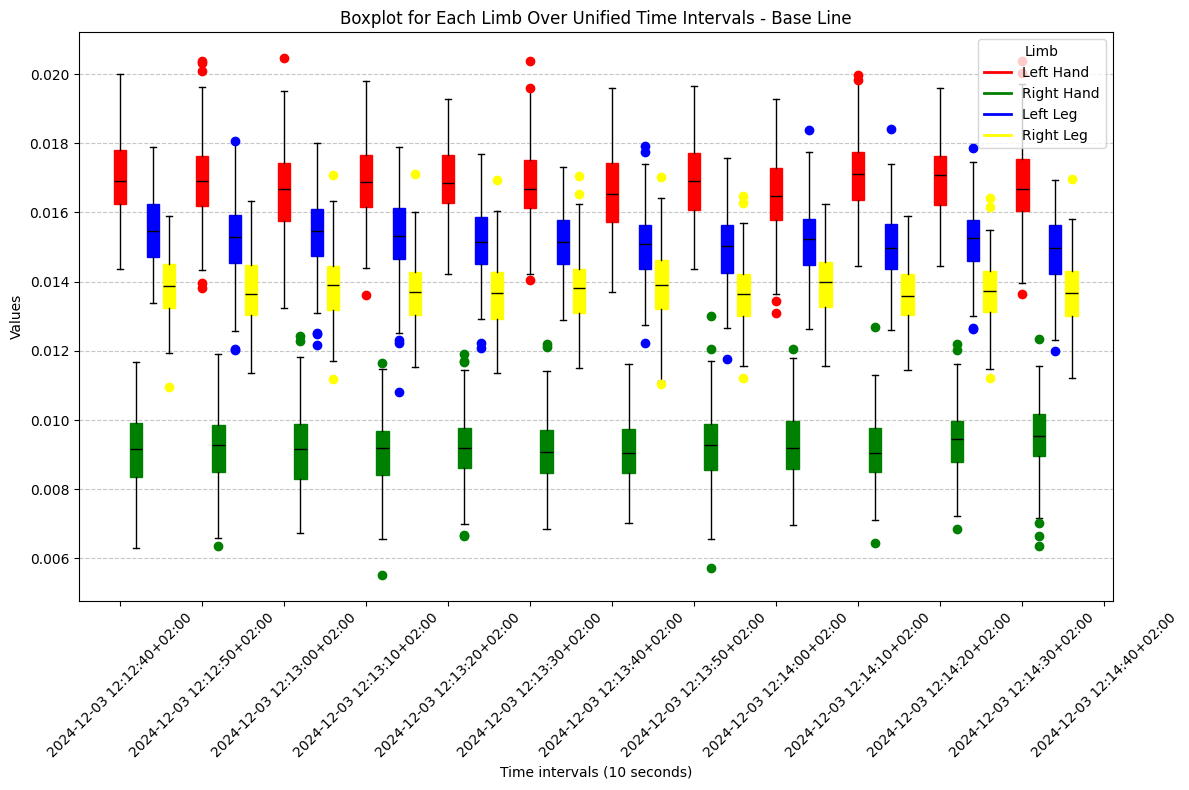

C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_intervals = [f"{str(idx)}" for idx in data.resample('10S').mean().index]
C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for start, end in zip(data.resample('10S').mean().index[:-1], data.resample('10S').mean().index[1:]):


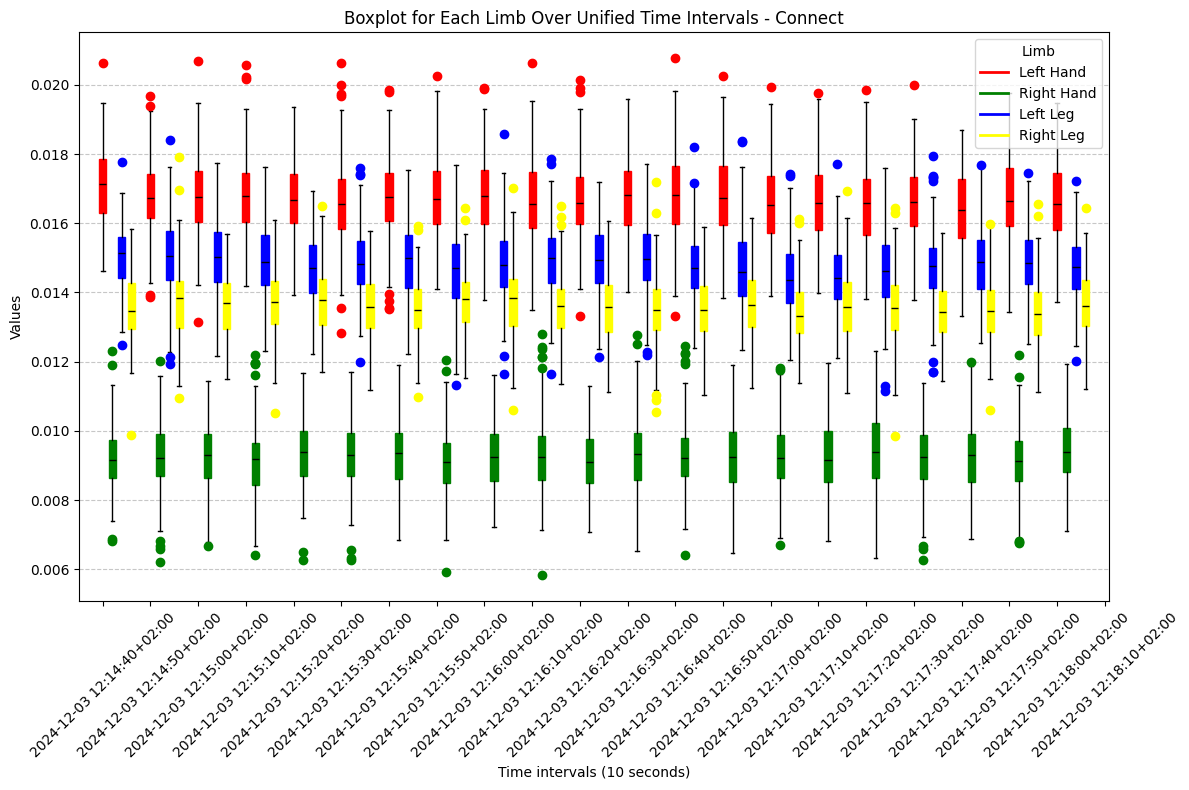

C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_intervals = [f"{str(idx)}" for idx in data.resample('10S').mean().index]
C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for start, end in zip(data.resample('10S').mean().index[:-1], data.resample('10S').mean().index[1:]):


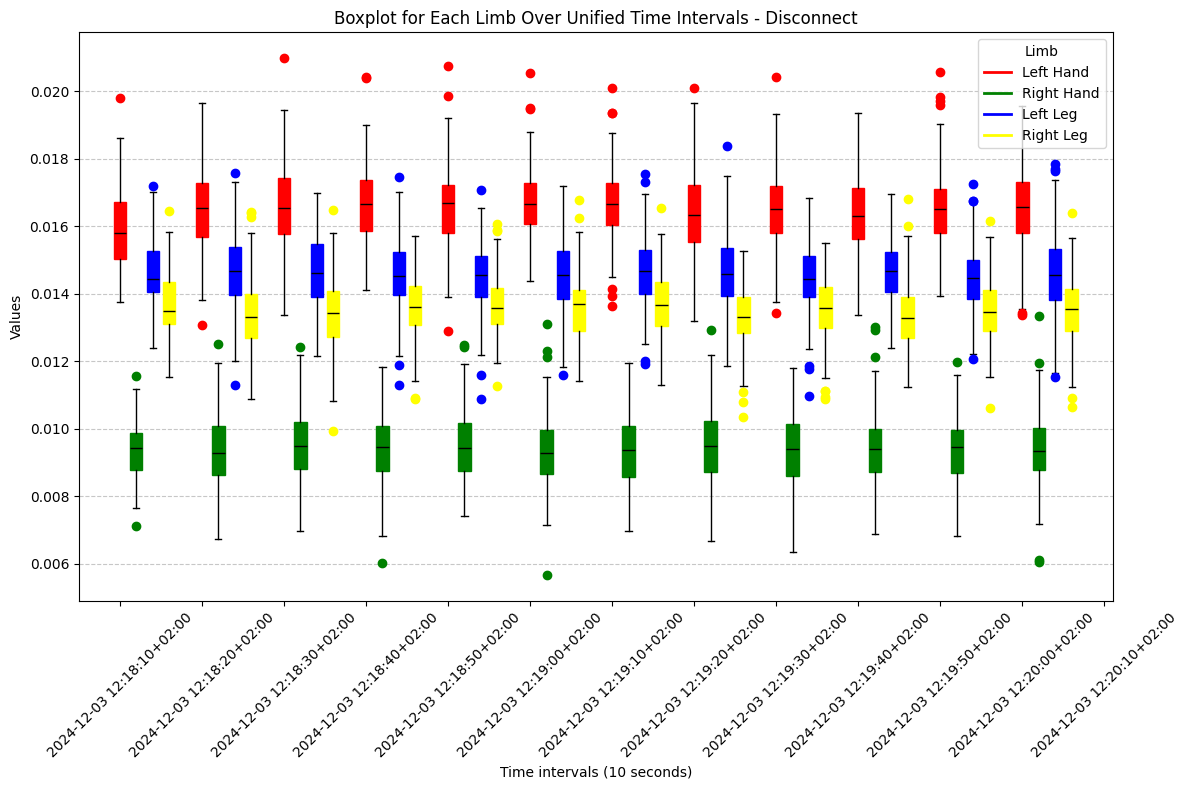

C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_intervals = [f"{str(idx)}" for idx in data.resample('10S').mean().index]
C:\Users\Liors\AppData\Local\Temp\ipykernel_22792\1374770587.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for start, end in zip(data.resample('10S').mean().index[:-1], data.resample('10S').mean().index[1:]):


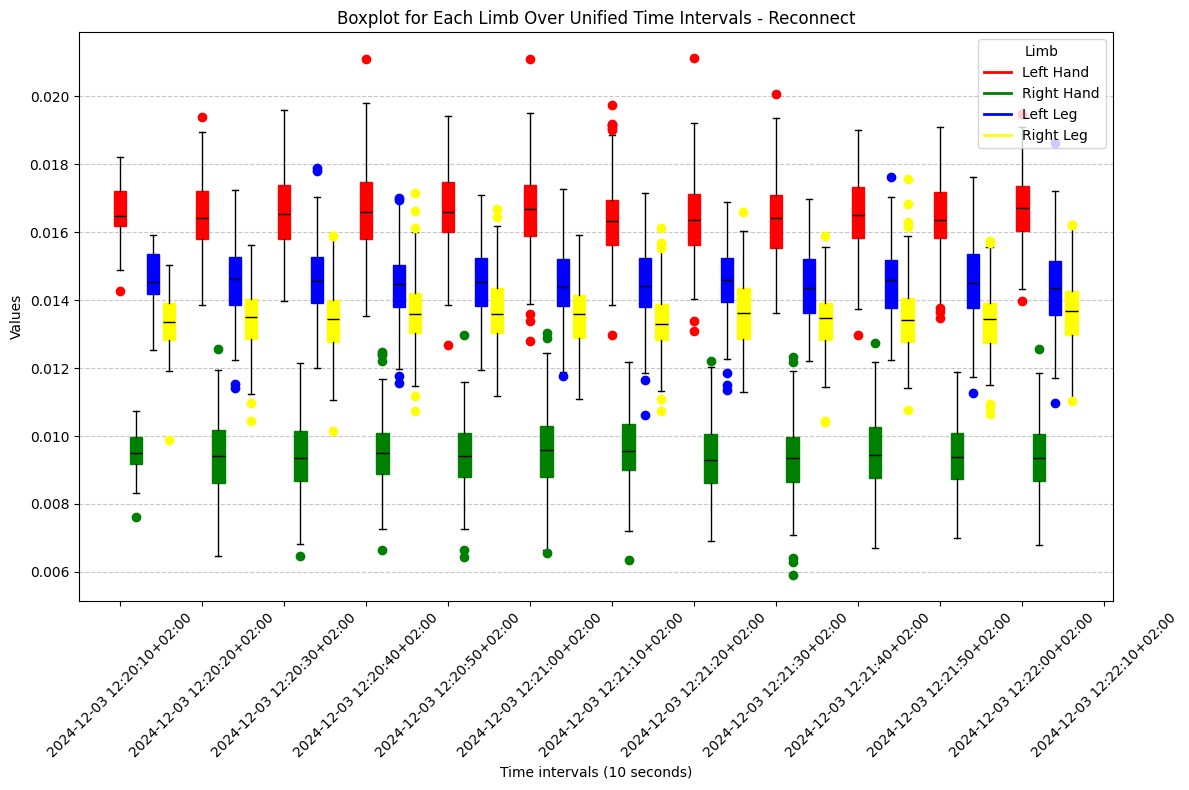

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Define the colors for each limb
colors = {
    'Left Hand': 'red',
    'Right Hand': 'green',
    'Left Leg': 'blue',
    'Right Leg': 'yellow',
}

# Iterate over each event in segmented_data
for event_name, data in segmented_data.items():
    # Resample the data into 10-second intervals and prepare data for each limb
    limb_data = {column: [] for column in data.columns}
    time_intervals = [f"{str(idx)}" for idx in data.resample('10S').mean().index]

    for column in data.columns:
        for start, end in zip(data.resample('10S').mean().index[:-1], data.resample('10S').mean().index[1:]):
            limb_data[column].append(data[column][start:end].values)

    # Plot the boxplot with specified colors for each limb
    plt.figure(figsize=(12, 8))
    for idx, (column, color) in enumerate(colors.items()):
        plt.boxplot(
            limb_data[column],
            positions=np.arange(len(limb_data[column])) + idx * 0.2,  # Offset for each limb
            widths=0.15,
            patch_artist=True,
            boxprops=dict(facecolor=color, color=color),
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor=color, markeredgecolor=color),
        )

    # Customize the plot
    plt.title(f"Boxplot for Each Limb Over Unified Time Intervals - {event_name}")
    plt.xlabel("Time intervals (10 seconds)")
    plt.ylabel("Values")
    plt.xticks(ticks=np.arange(len(time_intervals)), labels=time_intervals, rotation=45)
    plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=column) for column, color in colors.items()],
               title="Limb", loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:

# Perform the calculation for all items in segmented_data
all_stats = {}

for event_name, data in segmented_data.items():
    slot_duration = pd.Timedelta(seconds=10)
    start_time = data.index.min()
    end_time = data.index.max()

    stats_list = []
    current_time = start_time
    while current_time < end_time:
        next_time = current_time + slot_duration
        slot_data = data[(data.index >= current_time) & (data.index < next_time)]
        
        if not slot_data.empty:
            stats = {
                'start_time': current_time,
                'end_time': next_time,
                'mean': slot_data.mean(),
                'std': slot_data.std(),
                'min': slot_data.min(),
                'max': slot_data.max()
            }
            stats_list.append(stats)
        
        current_time = next_time

    stats_df = pd.DataFrame(stats_list)
    all_stats[event_name] = stats_df

# Print the statistics for each event
for event_name, stats_df in all_stats.items():
    print(f"Statistics for {event_name}:")
    print(stats_df)
    print("\n")

Statistics for Base Line:
                         start_time                         end_time  \
0  2024-12-03 12:12:42.176595+02:00 2024-12-03 12:12:52.176595+02:00   
1  2024-12-03 12:12:52.176595+02:00 2024-12-03 12:13:02.176595+02:00   
2  2024-12-03 12:13:02.176595+02:00 2024-12-03 12:13:12.176595+02:00   
3  2024-12-03 12:13:12.176595+02:00 2024-12-03 12:13:22.176595+02:00   
4  2024-12-03 12:13:22.176595+02:00 2024-12-03 12:13:32.176595+02:00   
5  2024-12-03 12:13:32.176595+02:00 2024-12-03 12:13:42.176595+02:00   
6  2024-12-03 12:13:42.176595+02:00 2024-12-03 12:13:52.176595+02:00   
7  2024-12-03 12:13:52.176595+02:00 2024-12-03 12:14:02.176595+02:00   
8  2024-12-03 12:14:02.176595+02:00 2024-12-03 12:14:12.176595+02:00   
9  2024-12-03 12:14:12.176595+02:00 2024-12-03 12:14:22.176595+02:00   
10 2024-12-03 12:14:22.176595+02:00 2024-12-03 12:14:32.176595+02:00   
11 2024-12-03 12:14:32.176595+02:00 2024-12-03 12:14:42.176595+02:00   

                                     

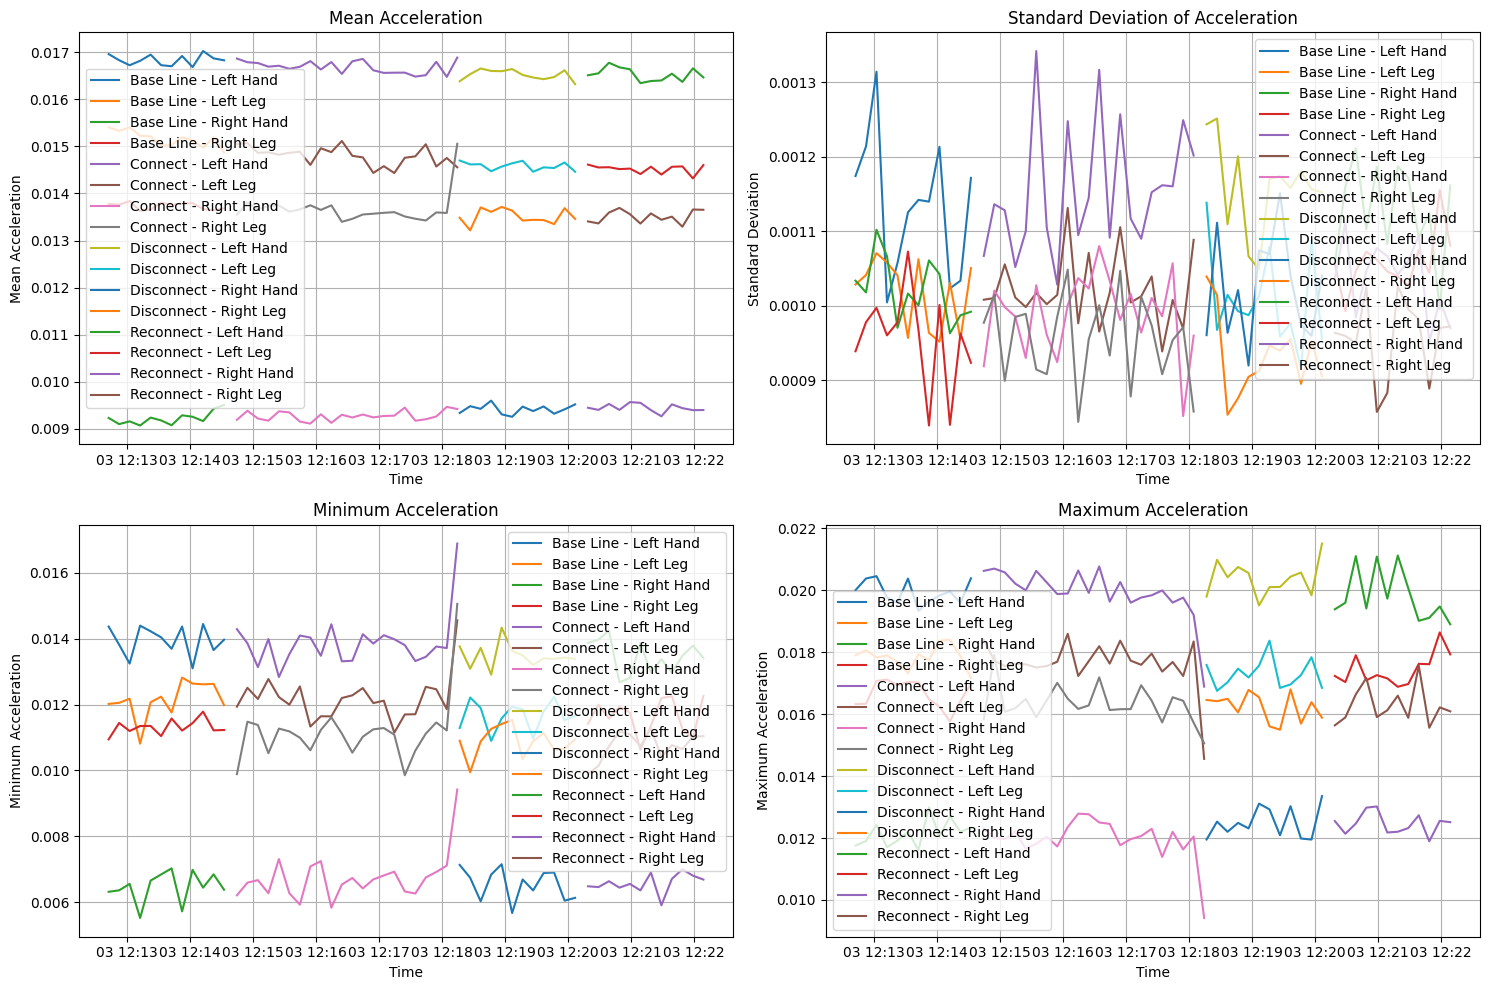

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot mean values
axes[0, 0].set_title('Mean Acceleration')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Mean Acceleration')
for event_name, stats_df in all_stats.items():
    for limb in ['Left Hand', 'Left Leg', 'Right Hand', 'Right Leg']:
        axes[0, 0].plot(stats_df['start_time'], stats_df['mean'].apply(lambda x: x[limb]), label=f'{event_name} - {limb}')

# Plot standard deviation values
axes[0, 1].set_title('Standard Deviation of Acceleration')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Standard Deviation')
for event_name, stats_df in all_stats.items():
    for limb in ['Left Hand', 'Left Leg', 'Right Hand', 'Right Leg']:
        axes[0, 1].plot(stats_df['start_time'], stats_df['std'].apply(lambda x: x[limb]), label=f'{event_name} - {limb}')

# Plot minimum values
axes[1, 0].set_title('Minimum Acceleration')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Minimum Acceleration')
for event_name, stats_df in all_stats.items():
    for limb in ['Left Hand', 'Left Leg', 'Right Hand', 'Right Leg']:
        axes[1, 0].plot(stats_df['start_time'], stats_df['min'].apply(lambda x: x[limb]), label=f'{event_name} - {limb}')

# Plot maximum values
axes[1, 1].set_title('Maximum Acceleration')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Maximum Acceleration')
for event_name, stats_df in all_stats.items():
    for limb in ['Left Hand', 'Left Leg', 'Right Hand', 'Right Leg']:
        axes[1, 1].plot(stats_df['start_time'], stats_df['max'].apply(lambda x: x[limb]), label=f'{event_name} - {limb}')

# Add legends
for ax in axes.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()